In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from nn_flip_weights import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

In [2]:
%%time 

dataset = 'Fashion-MNIST'
hidden_size = [64]

num_samples_per_class = 100000

# Easy task
class1 = 3
class2 = 2

activation_fn = '_sigmoid' # '' for relu

all_original_acc_easy = []
all_results_easy = []

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_easy, results_easy = flip_weights_mlp(9, path, [class1, class2], num_samples_per_class,
                                                       hidden_size, dataset=dataset, verbose=False)

    all_original_acc_easy.append(original_acc_easy)
    all_results_easy.append(results_easy)

100%|██████████| 30/30 [03:35<00:00,  7.20s/it]

CPU times: user 2d 11h 45min 34s, sys: 1min 30s, total: 2d 11h 47min 5s
Wall time: 1h 54min 58s


In [3]:
%%time

# Hard task
class1 = 3
class2 = 1

all_original_acc_hard = []
all_results_hard = []

for i in range(20):
    path = f'/home/rjankow/data/task_complexity/fix_accuracy/for_paper/output_fashion_mnist_classes_{class1}_{class2}_dim_{hidden_size[0]}_n_{num_samples_per_class}_i{i}{activation_fn}/'
    original_acc_hard, results_hard = flip_weights_mlp(9, path, [class1, class2], num_samples_per_class,
                                                       hidden_size, dataset=dataset, verbose=False)
    all_original_acc_hard.append(original_acc_hard)
    all_results_hard.append(results_hard)

100%|██████████| 30/30 [03:05<00:00,  6.18s/it]

CPU times: user 2d 56min 16s, sys: 1min 2s, total: 2d 57min 19s
Wall time: 1h 20min 51s


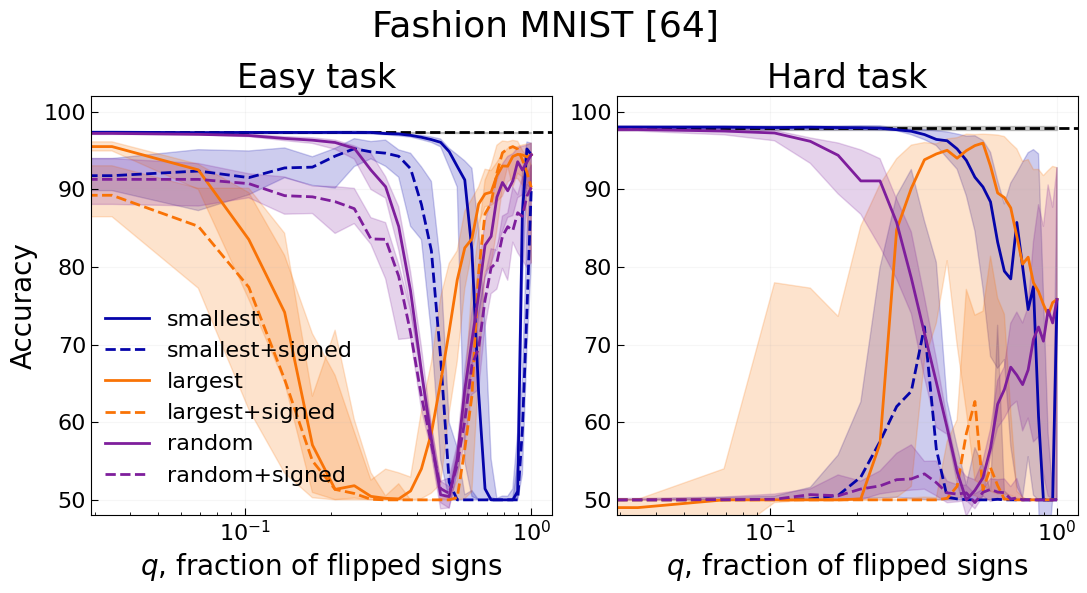

In [4]:
def plot_shaded_area(x, data, plot_style='median_iqr', label='', color='blue', alpha=0.2, linestyle='-'):
    """
    Plots a shaded area with a central line based on the provided data.
    
    Parameters:
      x (array-like): x-axis values.
      data (np.ndarray): 2D array where each row corresponds to a run.
      plot_style (str): 'mean_std' for mean ± standard deviation,
                        'median_iqr' for median with interquartile range.
      label (str): Label for the central line.
      color (str): Color for the shaded area and line.
      alpha (float): Transparency for the shaded area.
    """
    if plot_style == 'mean_std':
        central = np.mean(data, axis=0)
        lower = central - np.std(data, axis=0)
        upper = central + np.std(data, axis=0)
    elif plot_style == 'median_iqr':
        central = np.median(data, axis=0)
        lower = np.percentile(data, 25, axis=0)
        upper = np.percentile(data, 75, axis=0)
    else:
        raise ValueError("Unsupported plot_style. Use 'mean_std' or 'median_iqr'.")
        
    plt.fill_between(x, lower, upper, alpha=alpha, color=color)
    plt.plot(x, central, color=color, label=label, linestyle=linestyle)

def extract_values(results, index):
    """
    Extracts values from a list of dictionaries.
    
    Parameters:
      results (list): List of dictionaries with values as iterables.
      index (int): The index to extract from each value tuple.
      
    Returns:
      np.ndarray: 2D array with extracted values.
    """
    vals = []
    for r in results:
        vals.append([x[index] for x in r.values()])
    return np.array(vals)


x = np.array(list(all_results_easy[0].keys()))

plt.figure(figsize=(11, 6))

# ----------------- Easy Task -----------------
plt.subplot(1, 2, 1)
plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

vals_original_easy = extract_values(all_results_easy, 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
vals_signed_easy = extract_values(all_results_easy, 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')

vals_original_easy = extract_values(all_results_easy, 2)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='largest', color='xkcd:orange')
vals_signed_easy = extract_values(all_results_easy, 3)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='largest+signed', color='xkcd:orange', linestyle='--')

vals_original_easy = extract_values(all_results_easy, 4)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='random', color='xkcd:purple')
vals_signed_easy = extract_values(all_results_easy, 5)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='random+signed', color='xkcd:purple', linestyle='--')

plt.legend(loc=(0.01, 0.05))
plt.title(f'Easy task ')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.ylim(48, 102)

# ----------------- Hard Task -----------------
plt.subplot(1, 2, 2)
plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

vals_original_hard = extract_values(all_results_hard, 0)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
vals_signed_hard = extract_values(all_results_hard, 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')

vals_original_hard = extract_values(all_results_hard, 2)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='largest', color='xkcd:orange')
vals_signed_hard = extract_values(all_results_hard, 3)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='largest+signed', color='xkcd:orange', linestyle='--')

vals_original_hard = extract_values(all_results_hard, 4)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='random', color='xkcd:purple')
vals_signed_hard = extract_values(all_results_hard, 5)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='random+signed', color='xkcd:purple', linestyle='--')

plt.ylim(48, 102)
plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.title('Hard task')

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()

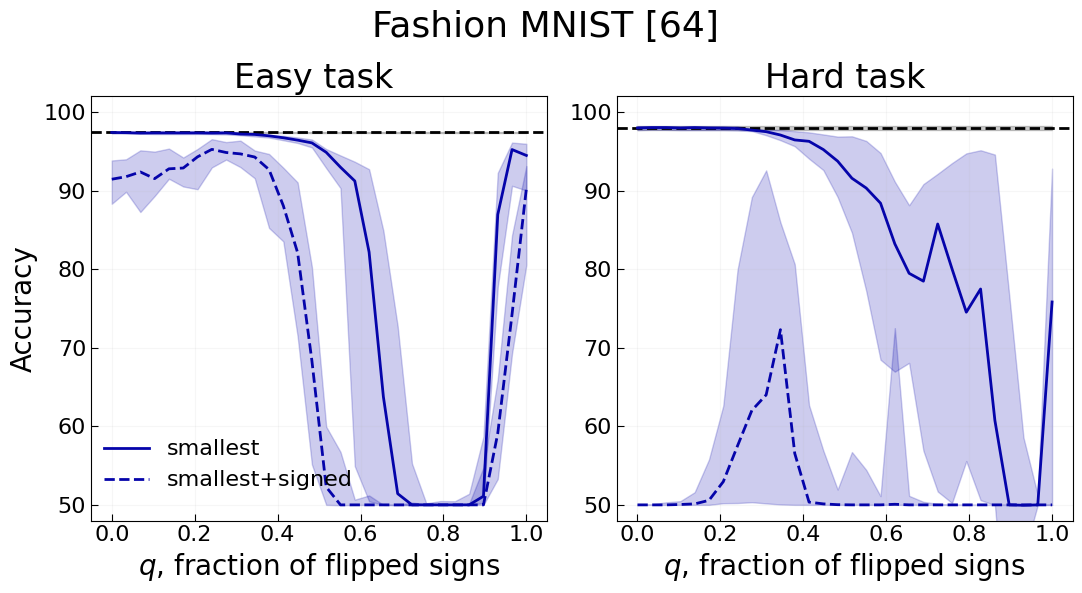

In [5]:
x = np.array(list(all_results_easy[0].keys()))

plt.figure(figsize=(11, 6))

# ----------------- Easy Task -----------------
plt.subplot(1, 2, 1)
plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

vals_original_easy = extract_values(all_results_easy, 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
vals_signed_easy = extract_values(all_results_easy, 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')

plt.legend(loc=(0.01, 0.05))
plt.title(f'Easy task ')
plt.ylabel('Accuracy')
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.ylim(48, 102)

# ----------------- Hard Task -----------------
plt.subplot(1, 2, 2)
plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

vals_original_hard = extract_values(all_results_hard, 0)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='smallest', color='xkcd:royal blue')
vals_signed_hard = extract_values(all_results_hard, 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='smallest+signed', color='xkcd:royal blue', linestyle='--')

plt.ylim(48, 102)
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.title('Hard task')

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()

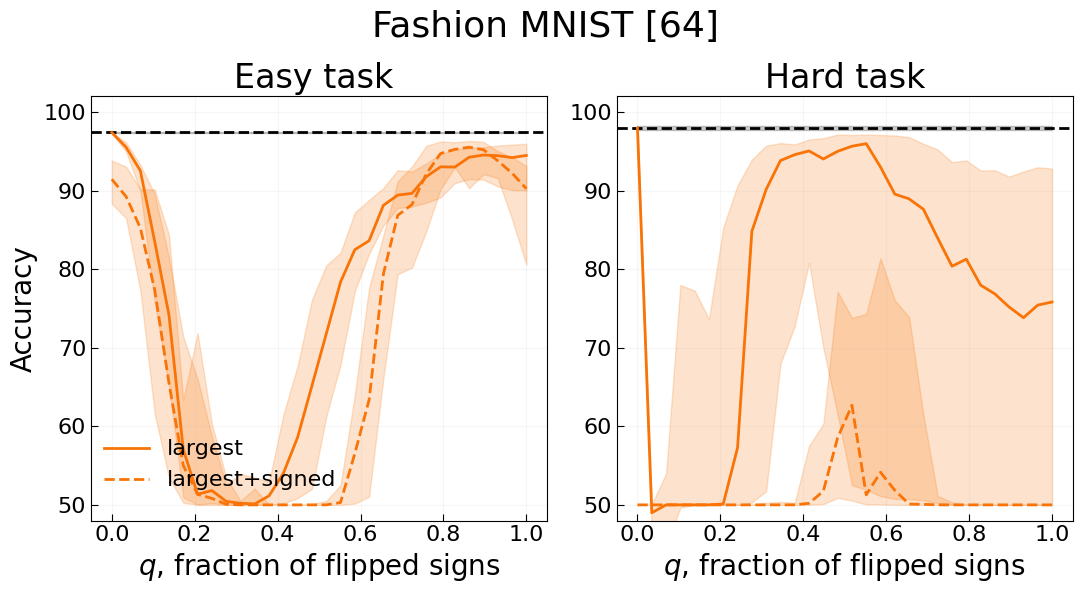

In [6]:
x = np.array(list(all_results_easy[0].keys()))

plt.figure(figsize=(11, 6))

# ----------------- Easy Task -----------------
plt.subplot(1, 2, 1)
plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

vals_original_easy = extract_values(all_results_easy, 2)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='largest', color='xkcd:orange')
vals_signed_easy = extract_values(all_results_easy, 3)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='largest+signed', color='xkcd:orange', linestyle='--')

plt.legend(loc=(0.01, 0.05))
plt.title(f'Easy task ')
plt.ylabel('Accuracy')
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.ylim(48, 102)

# ----------------- Hard Task -----------------
plt.subplot(1, 2, 2)
plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

vals_original_hard = extract_values(all_results_hard, 2)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='largest', color='xkcd:orange')
vals_signed_hard = extract_values(all_results_hard, 3)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='largest+signed', color='xkcd:orange', linestyle='--')

plt.ylim(48, 102)
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.title('Hard task')

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()

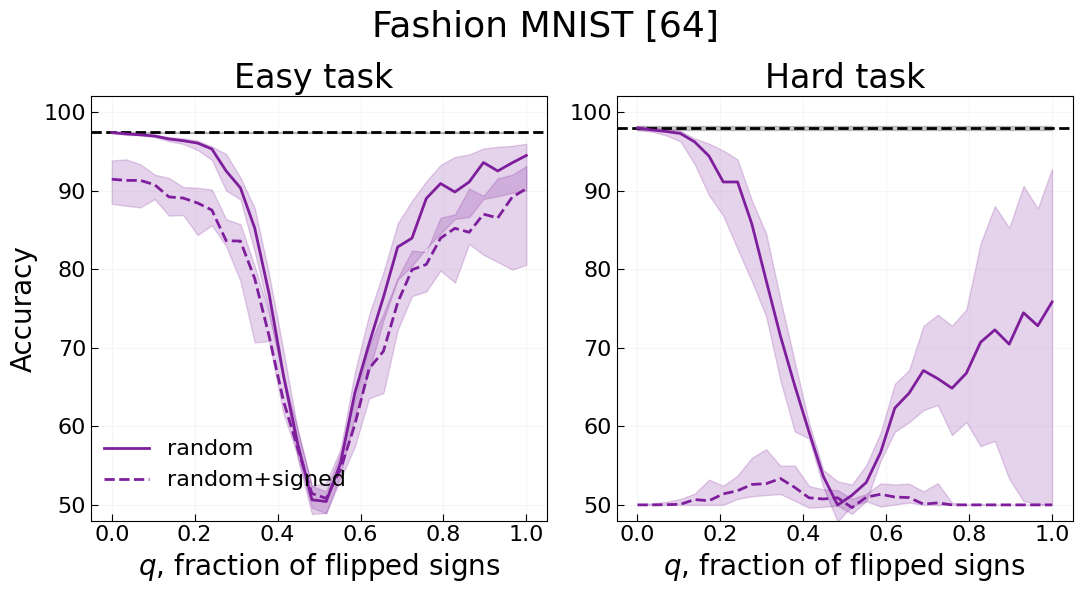

In [7]:
x = np.array(list(all_results_easy[0].keys()))

plt.figure(figsize=(11, 6))

# ----------------- Easy Task -----------------
plt.subplot(1, 2, 1)
plt.fill_between(x, np.percentile(all_original_acc_easy, 25), np.percentile(all_original_acc_easy, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_easy), linestyle='--', color='black')

vals_original_easy = extract_values(all_results_easy, 4)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='random', color='xkcd:purple')
vals_signed_easy = extract_values(all_results_easy, 5)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='random+signed', color='xkcd:purple', linestyle='--')

plt.legend(loc=(0.01, 0.05))
plt.title(f'Easy task ')
plt.ylabel('Accuracy')
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.ylim(48, 102)

# ----------------- Hard Task -----------------
plt.subplot(1, 2, 2)
plt.fill_between(x, np.percentile(all_original_acc_hard, 25), np.percentile(all_original_acc_hard, 75),
                 color='black', alpha=0.2)
plt.axhline(np.median(all_original_acc_hard), linestyle='--', color='black')

vals_original_hard = extract_values(all_results_hard, 4)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='random', color='xkcd:purple')
vals_signed_hard = extract_values(all_results_hard, 5)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='random+signed', color='xkcd:purple', linestyle='--')

plt.ylim(48, 102)
# plt.xscale('log')
plt.xlabel('$q$, fraction of flipped signs')
plt.title('Hard task')

plt.suptitle(f"Fashion MNIST [{hidden_size[0]}]", fontsize=26)
plt.tight_layout()

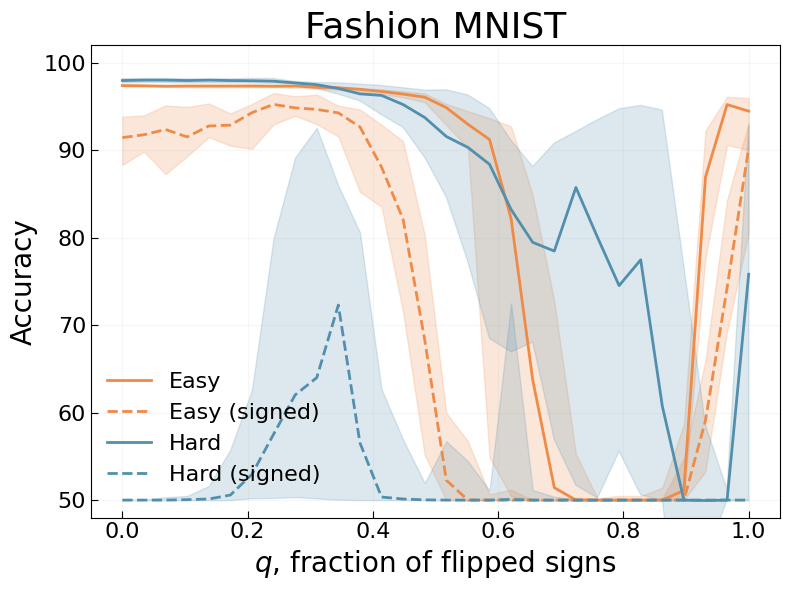

In [9]:
colors = ['#ef8a47', '#528fad']

x = np.array(list(all_results_easy[0].keys()))

vals_original_easy = extract_values(all_results_easy, 0)
plot_shaded_area(x, vals_original_easy, plot_style='median_iqr', label='Easy', color=colors[0])
vals_signed_easy = extract_values(all_results_easy, 1)
plot_shaded_area(x, vals_signed_easy, plot_style='median_iqr', label='Easy (signed)', color=colors[0], linestyle='--')

vals_original_hard = extract_values(all_results_hard, 0)
plot_shaded_area(x, vals_original_hard, plot_style='median_iqr', label='Hard', color=colors[1])
vals_signed_hard = extract_values(all_results_hard, 1)
plot_shaded_area(x, vals_signed_hard, plot_style='median_iqr', label='Hard (signed)', color=colors[1], linestyle='--')

plt.ylim(48, 102)
plt.legend(loc=(0.01, 0.05))
plt.xlabel('$q$, fraction of flipped signs')
plt.ylabel('Accuracy')

plt.title(f"Fashion MNIST", fontsize=26)
plt.tight_layout()

# plt.savefig("../plots/paper/flip_fashion_mnist_d64.pdf")
# plt.savefig("../plots/paper/flip_fashion_mnist_d32.pdf")
# plt.savefig("../plots/paper/flip_fashion_mnist_d128.pdf")

# plt.savefig("../plots/paper/flip_fashion_mnist_d64_sigmoid.pdf")